In [1]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tickers = pd.read_csv("https://www.cboe.com/us/equities/market_statistics/listed_symbols/csv", usecols=["Name"])

In [3]:
allTickerDF = pd.DataFrame()

In [4]:
for i in range(len(tickers["Name"])):
    currentTickerDF = yf.Ticker(tickers["Name"].iloc[i]).history(period="max")
    currentTickerDF['Name'] = tickers["Name"].iloc[i]
    allTickerDF = pd.concat([allTickerDF, currentTickerDF])

- QSPT: No data found, symbol may be delisted


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


- YSEP: No data found, symbol may be delisted


In [5]:
allTickerDF.sort_index(inplace=True)

In [6]:
allTickerDF.tail()

,Adj Close,Close,Dividends,High,Low,Name,Open,Stock Splits,Volume
Date,,,,,,,,,
2021-09-20,NaN,55.529999,0.0,55.529999,55.480000,IAGG,55.500000,0.0,282800.0
2021-09-20,NaN,28.799999,0.0,28.879999,28.389999,SVAL,28.870001,0.0,223300.0
2021-09-20,NaN,79.959999,0.0,80.209999,79.000000,BBUS,80.110001,0.0,46100.0
2021-09-20,NaN,30.559999,0.0,30.559999,30.400000,OCTZ,30.400000,0.0,1800.0
2021-09-20,NaN,20.733999,0.0,20.733999,20.683001,YMAR,20.683001,0.0,1400.0


In [7]:
allTickerDF = allTickerDF.reset_index().pivot(index="Date", values=["Open", "High", "Low", "Close", "Volume", "Dividends", "Stock Splits"], columns='Name')

In [8]:
allTickerDF

Open                                                       \
Name             ACIO       ACSI        ACWV  ADFI       ADME   AESR  AFIF   
Date                                                                         
2000-05-26        NaN        NaN         NaN   NaN        NaN    NaN   NaN   
2000-05-30        NaN        NaN         NaN   NaN        NaN    NaN   NaN   
2000-05-31        NaN        NaN         NaN   NaN        NaN    NaN   NaN   
2000-06-01        NaN        NaN         NaN   NaN        NaN    NaN   NaN   
2000-06-02        NaN        NaN         NaN   NaN        NaN    NaN   NaN   
...               ...        ...         ...   ...        ...    ...   ...   
2021-09-14  30.959999  50.377998  106.620003  9.79  41.200001  14.14  9.71   
2021-09-15  30.629999  50.789001  106.379997  9.77  40.780998  14.07  9.68   
2021-09-16  30.719999  50.895000  106.110001  9.76  40.900002  14.11  9.67   
2021-09-17  30.670000  50.598000  105.949997  9.75  40.889999  14.15  9.68   
2021-09-20  30.350000  49.485001  104.320000  9.77  39.840000  13.83  9.69   

                                             ... Stock Splits                 \
Name              AGT       ALFA       ALTS  ...         XSHD XSHQ XTAP XTJL   
Date                                         ...                               
2000-05-26        NaN        NaN        NaN  ...          NaN  NaN  NaN  NaN   
2000-05-30        NaN        NaN        NaN  ...          NaN  NaN  NaN  NaN   
2000-05-31        NaN        NaN        NaN  ...          NaN  NaN  NaN  NaN   
2000-06-01        NaN        NaN        NaN  ...          NaN  NaN  NaN  NaN   
2000-06-02        NaN        NaN        NaN  ...          NaN  NaN  NaN  NaN   
...               ...        ...        ...  ...          ...  ...  ...  ...   
2021-09-14  31.290001  86.800003  39.029999  ...          0.0  0.0  0.0  0.0   
2021-09-15  31.000000  87.589996  39.060001  ...          0.0  0.0  0.0  0.0   
2021-09-16  30.940001  88.059998  39.000000  ...          0.0  0.0  0.0  0.0   
2021-09-17  31.049999  88.279999  38.959999  ...          0.0  0.0  0.0  0.0   
2021-09-20  29.934999  86.360001  38.779999  ...          0.0  0.0  0.0  0.0   

                                          
Name        XVV YDEC YJUN YMAR  YPS ZECP  
Date                                      
2000-05-26  NaN  NaN  NaN  NaN  NaN  NaN  
2000-05-30  NaN  NaN  NaN  NaN  NaN  NaN  
2000-05-31  NaN  NaN  NaN  NaN  NaN  NaN  
2000-06-01  NaN  NaN  NaN  NaN  NaN  NaN  
2000-06-02  NaN  NaN  NaN  NaN  NaN  NaN  
...         ...  ...  ...  ...  ...  ...  
2021-09-14  0.0  0.0  0.0  0.0  0.0  0.0  
2021-09-15  0.0  0.0  0.0  0.0  0.0  0.0  
2021-09-16  0.0  0.0  0.0  0.0  0.0  0.0  
2021-09-17  0.0  0.0  0.0  0.0  0.0  0.0  
2021-09-20  0.0  0.0  0.0  0.0  0.0  0.0  

[5363 rows x 3542 columns]

We are trying to predict the closing price one day ahead

* does y need scaled???

In [ ]:
def create_train_test(data, startDate, numberOfDays=3):
    data = data.loc[startDate:].iloc[:numberOfDays+2].dropna(axis=1)

    train = data.iloc[:numberOfDays+1]
    test = data.iloc[1:numberOfDays+2]
    
    scaler = MinMaxScaler()
    scaler.fit(train)

    train_scaled = scaler.transform(train)
    test_scaled = scaler.transform(test)

    indicesForClose = train.columns.get_loc("Close")

    X_train_scaled = train_scaled[:numberOfDays]
    y_train_scaled = train_scaled[numberOfDays, indicesForClose.start:indicesForClose.stop]
    
    # Test split - this will be a day in advance of the model
    X_test_scaled = test_scaled[:numberOfDays]
    #y_test_scaled = test_scaled[numberOfDays, indicesForClose.start:indicesForClose.stop]
    y_test = test.iloc[numberOfDays, indicesForClose.start:indicesForClose.stop]
        
    #return X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, scaler
    return X_train_scaled, y_train_scaled, X_test_scaled, y_test, scaler, indicesForClose

In [9]:
data=allTickerDF
startDate='2019-01-01'
timeSteps=60


#data = data.loc[startDate:].iloc[:numberOfDays+2].dropna(axis=1)

data = data.loc[startDate:].dropna(axis=1)

print(len(data))

685


In [10]:
trainSize = int(len(data)*0.8)
testSize = len(data) - trainSize

In [11]:
print(trainSize)
print(testSize)

548
137


In [12]:
train = data.iloc[:trainSize]
test = data.iloc[trainSize:]

scaler = MinMaxScaler()
scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

indicesForClose = data.columns.get_loc("Close")

In [13]:
indicesForClose.start
indicesForClose.stop

820

In [14]:
X_train = []
y_train = []

for i in range(timeSteps, trainSize):
    X_train.append(train_scaled[i-timeSteps:i])
    # This could be replaced with y_train.append(train_scaled[i], indicesForClose.start:indicesForClose.stop)
    y_train.append(train.iloc[i, indicesForClose.start:indicesForClose.stop])

X_test = []
y_test = []
    
for i in range(timeSteps, testSize):
    X_test.append(test_scaled[i-timeSteps:i])
    # This could be replaced by y_test.append(test_scaled[i], indicesForClose.start:indicesForClose.stop)
    y_test.append(test.iloc[i, indicesForClose.start:indicesForClose.stop])

In [15]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [16]:
y_train.shape

(488, 205)

In [17]:
# Scaling the y values
scaler_y = MinMaxScaler()
scaler_y.fit(y_train)

y_train = scaler_y.transform(y_train)
y_test = scaler_y.transform(y_test)

In [18]:
y_test

array([[1.16201086, 1.1753707 , 1.16698594, ..., 1.08725132, 1.13241838,
        1.22292049],
       [1.15220344, 1.17641299, 1.15573912, ..., 1.0849    , 1.11464388,
        1.22227031],
       [1.1570129 , 1.19898525, 1.18432535, ..., 1.08960287, 1.11229802,
        1.2300725 ],
       ...,
       [1.2441008 , 1.30974757, 1.37440129, ..., 1.19493446, 0.95272135,
        1.22162013],
       [1.23009691, 1.28801812, 1.34439235, ..., 1.19020588, 0.95780621,
        1.20443672],
       [1.18638802, 1.25086801, 1.2909389 , ..., 1.17129089, 0.93465191,
        1.17118425]])

In [ ]:
#X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, scaler = create_train_test(data=allTickerDF, startDate='2021-01-04')
#X_train_scaled, y_train_scaled, X_test_scaled, y_test, scaler, indicesForClose = create_train_test(data=allTickerDF, startDate='2021-01-04')

In [ ]:
#X_train_scaled = np.expand_dims(X_train_scaled, axis = 0)
#y_train = y_train.to_numpy().reshape(1,-1)

#X_test_scaled = np.expand_dims(X_test_scaled, axis = 0)
#y_test = y_test.to_numpy().reshape(1,-1)

In [ ]:
# print(X_train_scaled.shape)
# print(y_train.shape)

# print(X_test_scaled.shape)
# print(y_test.shape)

In [ ]:
y_train

In [ ]:
X_train.shape[1]

In [ ]:
y_train.shape[1]

In [ ]:
# Create variables for X_train.shape[2] etc to make it easier to understand what these are

In [19]:
model = Sequential()
model.add(LSTM(units=X_train.shape[2],return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=X_train.shape[2],return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=X_train.shape[2],return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=X_train.shape[2]))
model.add(Dropout(0.2))
model.add(Dense(units=X_train.shape[2]))
model.add(Dense(units=y_train.shape[1]))
model.compile(optimizer='adam',loss='mean_squared_error')

history = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=25,batch_size=8, verbose=1)

#history = model.fit(XTrain, yTrain, epochs=epoch_value, validation_data=(XTest, yTest), batch_size=batch_value, verbose=0)

Epoch 1/25
61/61 [==============================] - 1473s 24s/step - loss: 0.1898 - val_loss: 0.3391
Epoch 2/25
61/61 [==============================] - 1246s 20s/step - loss: 0.0481 - val_loss: 0.2576
Epoch 3/25
61/61 [==============================] - 1370s 22s/step - loss: 0.0546 - val_loss: 0.2384
Epoch 4/25
61/61 [==============================] - 1414s 23s/step - loss: 0.0462 - val_loss: 0.2231
Epoch 5/25
61/61 [==============================] - 1429s 23s/step - loss: 0.0468 - val_loss: 0.2045
Epoch 6/25
61/61 [==============================] - 1348s 22s/step - loss: 0.0334 - val_loss: 0.0561
Epoch 7/25
61/61 [==============================] - 1581s 26s/step - loss: 0.0255 - val_loss: 0.1086
Epoch 8/25
61/61 [==============================] - 1669s 27s/step - loss: 0.0228 - val_loss: 0.0805
Epoch 9/25
61/61 [==============================] - 1417s 23s/step - loss: 0.0201 - val_loss: 0.1130
Epoch 10/25
61/61 [==============================] - 1329s 22s/step - loss: 0.0217 - val_lo

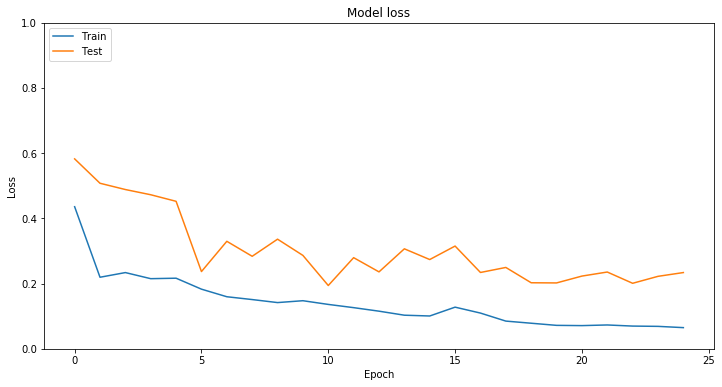

In [24]:
# Plot training & validation loss values
plt.figure(figsize=(12,6))
plt.plot(np.sqrt(history.history['loss']))
plt.plot(np.sqrt(history.history['val_loss']))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim(top=1, bottom=0)
plt.show()

# Get the MSE
mse = model.evaluate(X_test, y_test, verbose=0) 

# Get the RMSE by getting the square root of the MSE
rmse = mse ** 0.5

epochForMinMSEValue = history.history['val_loss'].index(min(history.history['val_loss']))
minMSEValue = min(history.history['val_loss'])

In [21]:
print(epochForMinMSEValue)
print(minMSEValue)

10
0.037653204053640366


### Re do model with best epoch (reword>............

In [22]:
X_train.shape[2]

1435

In [25]:
model = Sequential()
model.add(LSTM(units=X_train.shape[2],return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=X_train.shape[2],return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=X_train.shape[2],return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=X_train.shape[2]))
model.add(Dropout(0.2))
model.add(Dense(units=X_train.shape[2]))
model.add(Dense(units=y_train.shape[1]))
model.compile(optimizer='adam',loss='mean_squared_error')

model.fit(X_train,y_train, epochs=20, batch_size=8, verbose=1)

Epoch 1/20
61/61 [==============================] - 1408s 23s/step - loss: 0.1330
Epoch 2/20
61/61 [==============================] - 1278s 21s/step - loss: 0.0314
Epoch 3/20
61/61 [==============================] - 1234s 20s/step - loss: 0.0216
Epoch 4/20
61/61 [==============================] - 1257s 21s/step - loss: 0.0203
Epoch 5/20
61/61 [==============================] - 1264s 21s/step - loss: 0.0196
Epoch 6/20
61/61 [==============================] - 1346s 22s/step - loss: 0.0164
Epoch 7/20
61/61 [==============================] - 1341s 22s/step - loss: 0.0121
Epoch 8/20
61/61 [==============================] - 1348s 22s/step - loss: 0.0137
Epoch 9/20
61/61 [==============================] - 1347s 22s/step - loss: 0.0092
Epoch 10/20
61/61 [==============================] - 1272s 21s/step - loss: 0.0075
Epoch 11/20
61/61 [==============================] - 1317s 22s/step - loss: 0.0075
Epoch 12/20
61/61 [==============================] - 1336s 22s/step - loss: 0.0062
Epoch 13/20
6

In [ ]:
X_test[0]

In [26]:
predicted = model.predict(X_test)

In [27]:
predicted.shape

(77, 205)

In [31]:
predicted

array([[0.97259617, 0.95280147, 0.9329322 , ..., 0.90912557, 0.92698044,
        0.9318432 ],
       [0.97281545, 0.9528503 , 0.9330654 , ..., 0.9092432 , 0.9272586 ,
        0.932076  ],
       [0.97212875, 0.9525675 , 0.93234694, ..., 0.90881795, 0.92685306,
        0.931484  ],
       ...,
       [0.97608185, 0.9529871 , 0.93639356, ..., 0.91080916, 0.92908543,
        0.9348299 ],
       [0.9759378 , 0.95294017, 0.9362559 , ..., 0.9107224 , 0.9289782 ,
        0.93470085],
       [0.97555506, 0.95272803, 0.93593836, ..., 0.9104827 , 0.9286189 ,
        0.93432736]], dtype=float32)

In [41]:
scaler_y.inverse_transform(y_test)

array([[ 49.15399933, 102.32585144,  38.74822998, ...,  29.41910934,
         24.14300919,  23.3920002 ],
       [ 48.94599915, 102.35559082,  38.62829971, ...,  29.39921951,
         23.947258  ,  23.38500023],
       [ 49.04800034, 102.99964142,  38.93312836, ...,  29.43900108,
         23.92142296,  23.46899986],
       ...,
       [ 50.89500046, 106.16000366,  40.95999908, ...,  30.32999992,
         22.16399956,  23.37800026],
       [ 50.59799957, 105.54000092,  40.63999939, ...,  30.29000092,
         22.21999931,  23.19300079],
       [ 49.67100143, 104.48000336,  40.06999969, ...,  30.12999916,
         21.96500015,  22.83499908]])

In [37]:
scaler_y.inverse_transform(predicted)

array([[45.136806, 95.97533 , 36.252403, ..., 27.912346, 21.880514,
        20.258213],
       [45.141457, 95.976715, 36.253822, ..., 27.91334 , 21.883577,
        20.26072 ],
       [45.126892, 95.96864 , 36.246162, ..., 27.909744, 21.87911 ,
        20.254345],
       ...,
       [45.21073 , 95.98061 , 36.28931 , ..., 27.926586, 21.903696,
        20.290369],
       [45.20768 , 95.97928 , 36.287846, ..., 27.925852, 21.902515,
        20.288979],
       [45.19956 , 95.97323 , 36.28446 , ..., 27.923824, 21.898558,
        20.284958]], dtype=float32)

In [ ]:
### Retry above with single feature - close

In [ ]:
### Retry above with stock valuation (ie OHLC * volume)

In [ ]:
### Retry above with single stock and single feature - close

### To do
* Create function for getting train and test
* Create function for model that will return graph and min MSE